In [2]:
import pandas as pd
from sqlalchemy import create_engine, text
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
engine = create_engine("postgresql+psycopg2://")

# Reference Data

# Enrollments

Select all enrollments for intervention patients in `client4` or `client1` or `client6`

All enrollments are included so that when we build enrollment "sequences" for each patient, we can utilize ADE IDs from other EAs in the sequence if they have them already. This also lets us inspect the state of each enrollment sequence and have an opportunity to correct sequences that contain multiple ADE IDs due to new discharges occurring.

In [4]:
salesforce_patient_contact_filter = """
and lower(salesforce_contact.control_type) = 'intervention'
and salesforce_contact.patient_id not in (select patient_id from datascience.all_test_patients)
and salesforce_contact.iid in ('client4', 'client1', 'client6')
"""

In [5]:
patient_enrollments_sql = text(f"""
select
    salesforce_task.id,
    salesforce_task.task_type,
    salesforce_contact.patient_id,
    salesforce_task.time_created,
    salesforce_task.associated_discharge_event_id
from salesforce_task
join salesforce_contact on salesforce_task.who_id = salesforce_contact.id
where task_type ilike '%enrollment%'
{salesforce_patient_contact_filter}
""")
enrollment_attempts_df = pd.read_sql(patient_enrollments_sql, engine)
enrollment_attempts_df.info()
enrollment_attempts_df["associated_discharge_event_id"].isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37876 entries, 0 to 37875
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             37876 non-null  object        
 1   task_type                      37876 non-null  object        
 2   patient_id                     37876 non-null  object        
 3   time_created                   37876 non-null  datetime64[ns]
 4   associated_discharge_event_id  24578 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 1.4+ MB


False    24578
True     13298
Name: associated_discharge_event_id, dtype: int64

<AxesSubplot:xlabel='month_created'>

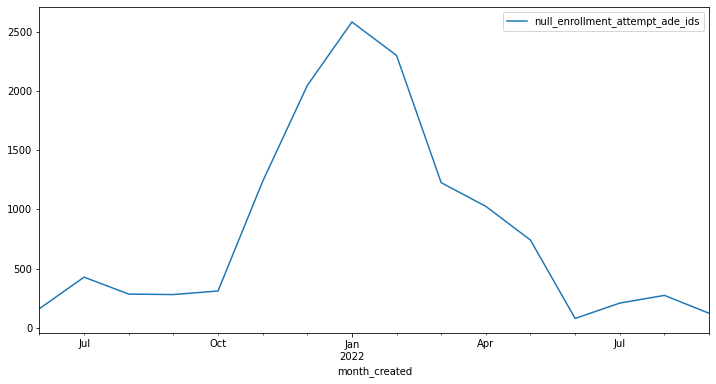

In [6]:
enrollment_attempts_df_copy = enrollment_attempts_df.copy()
enrollment_attempts_df_copy["month_created"] = enrollment_attempts_df_copy["time_created"].dt.to_period("M")
null_enrollment_attempts_by_month = enrollment_attempts_df_copy.associated_discharge_event_id.isnull().groupby(
    enrollment_attempts_df_copy["month_created"]).sum().rename("null_enrollment_attempt_ade_ids")
null_enrollment_attempts_by_month.plot.line(figsize=(12, 6), legend=True)

# MRPs / CMMs

Select all MRPs and CMMs for intervention patients in `client4` or `client1` or `client6`

In [7]:
patient_mrps_sql = text(f"""
select
    salesforce_event.id,
    salesforce_event.event_type,
    salesforce_contact.patient_id,
    salesforce_event.time_created,
    salesforce_event.associated_discharge_event_id
from salesforce_event
join salesforce_contact on salesforce_event.who_id = salesforce_contact.id
where (event_type ilike 'mrp' or event_type ilike '%encounter')
{salesforce_patient_contact_filter}
""")
patient_mrps_df = pd.read_sql(patient_mrps_sql, engine)
patient_mrps_df.info()
patient_mrps_df["associated_discharge_event_id"].isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11156 entries, 0 to 11155
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             11156 non-null  object        
 1   event_type                     11156 non-null  object        
 2   patient_id                     11156 non-null  object        
 3   time_created                   11156 non-null  datetime64[ns]
 4   associated_discharge_event_id  6365 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 435.9+ KB


False    6365
True     4791
Name: associated_discharge_event_id, dtype: int64

<AxesSubplot:xlabel='month_created'>

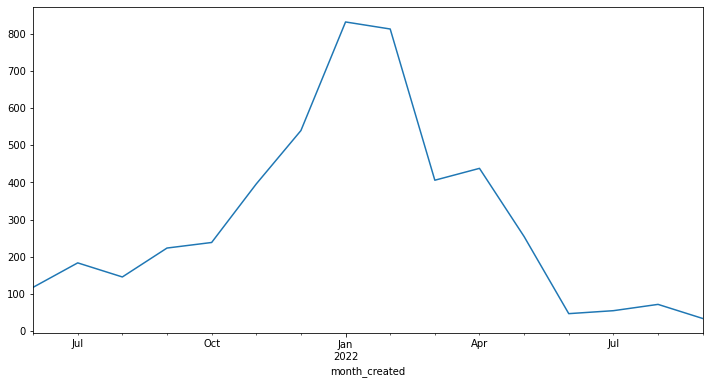

In [8]:
mrps_df_copy = patient_mrps_df.copy()
mrps_df_copy["month_created"] = mrps_df_copy["time_created"].dt.to_period("M")
null_mrps_by_month = mrps_df_copy.associated_discharge_event_id.isnull().groupby(
    mrps_df_copy["month_created"]).sum().rename("null_mrp_ade_ids")
null_mrps_by_month.plot.line(figsize=(12, 6))

# MAP Sends

Select all MAP sends for intervention patients in `client4` or `client1`

In [9]:
patient_map_sends_sql = text(f"""
select
    salesforce_task.id,
    salesforce_task.task_type,
    salesforce_contact.patient_id,
    salesforce_task.time_created,
    salesforce_task.associated_discharge_event_id
from salesforce_task
join salesforce_contact on salesforce_task.who_id = salesforce_contact.id
where task_type ilike 'document send%'
{salesforce_patient_contact_filter}
""")
patient_map_sends_df = pd.read_sql(patient_map_sends_sql, engine)
patient_map_sends_df.info()
patient_map_sends_df["associated_discharge_event_id"].isnull().value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17280 entries, 0 to 17279
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             17280 non-null  object        
 1   task_type                      17280 non-null  object        
 2   patient_id                     17280 non-null  object        
 3   time_created                   17280 non-null  datetime64[ns]
 4   associated_discharge_event_id  10953 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 675.1+ KB


False    10953
True      6327
Name: associated_discharge_event_id, dtype: int64

<AxesSubplot:xlabel='month_created'>

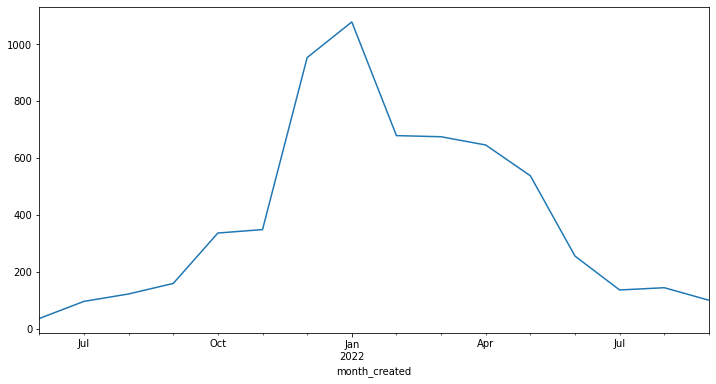

In [10]:
patient_map_sends_df_copy = patient_map_sends_df.copy()
patient_map_sends_df_copy["month_created"] = patient_map_sends_df_copy["time_created"].dt.to_period("M")
null_map_sends_by_month = patient_map_sends_df_copy.associated_discharge_event_id.isnull().groupby(
    patient_map_sends_df_copy["month_created"]).sum().rename("null_map_send_ade_ids")
null_map_sends_by_month.plot.line(figsize=(12, 6))

In [11]:
# medlists
patient_medlists_sql = text(f"""
select
    fact_medlist.id,
    salesforce_contact.patient_id,
    fact_medlist.time_created,
    null as associated_discharge_event_id
from salesforce_contact
join fact_medlist on salesforce_contact.patient_id = fact_medlist.patient_id
where 1 = 1
{salesforce_patient_contact_filter}
""")
patient_medlists_df = pd.read_sql(patient_medlists_sql, engine)
patient_medlists_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17320 entries, 0 to 17319
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   id                             17320 non-null  object        
 1   patient_id                     17320 non-null  object        
 2   time_created                   17320 non-null  datetime64[ns]
 3   associated_discharge_event_id  0 non-null      object        
dtypes: datetime64[ns](1), object(3)
memory usage: 541.4+ KB


<AxesSubplot:xlabel='month_created'>

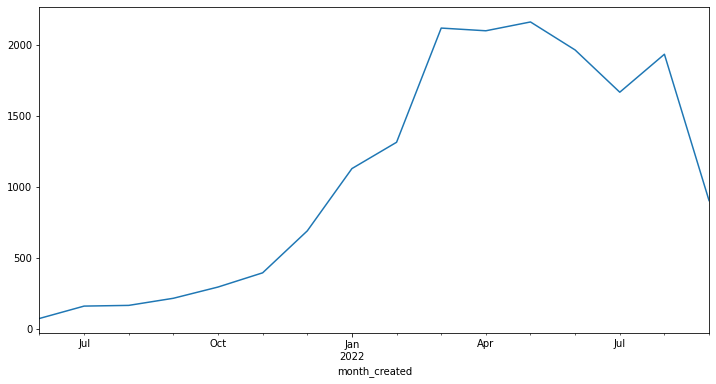

In [12]:
patient_medlists_df_copy = patient_medlists_df.copy()
patient_medlists_df_copy["month_created"] = patient_medlists_df_copy["time_created"].dt.to_period("M")
null_medlists_by_month = patient_medlists_df_copy.associated_discharge_event_id.isnull().groupby(
    patient_medlists_df_copy["month_created"]).sum().rename("null_medlist_ade_ids")
null_medlists_by_month.plot.line(figsize=(12, 6))

# Discharges

Select all discharges for patients who have had an enrollment attempt made

There are some patients how have had enrollments created from non-home discharges. For those patients,
fall back to any discharge event. This currently occurs for about 43~ patients.

In [13]:
patient_discharges_sql = text(f"""
with sf_missing_adeid as (
    select
        patient_id
    from salesforce_task
    join salesforce_contact on salesforce_task.who_id = salesforce_contact.id
    where 1 = 1
    {salesforce_patient_contact_filter}

    union

    select
        patient_id
    from salesforce_event
    join salesforce_contact on salesforce_event.who_id = salesforce_contact.id
    where 1 = 1
    {salesforce_patient_contact_filter}
),

home_discharges as (
    select
        fpe.id,
        fpe.time_event,
        fpemp.patient_id
    from sf_missing_adeid
    join fact_patient_event_matched_patient fpemp on sf_missing_adeid.patient_id = fpemp.patient_id
    join fact_patient_event fpe on fpemp.event_id = fpe.id
    where event_type = 'A03'
      and logical_event_type = 'HD'

),

wph_discharges as (

     select
         fpe.id,
         fpe.time_event,
         client6_patients.id as patient_id
     from sf_missing_adeid
     join dim_patient client6_patients on sf_missing_adeid.patient_id = client6_patients.id
     join dim_patient wph_patients on client6_patients.pid = wph_patients.pid
     join fact_patient_event_matched_patient fpemp on wph_patients.id = fpemp.patient_id
     join fact_patient_event fpe on fpemp.event_id = fpe.id
     where event_type = 'A03'
       and logical_event_type = 'HD'
       and wph_patients.iid = 'wph'

),

patients_missing_discharges as (

    select patient_id
    from sf_missing_adeid

    except

    select patient_id
    from home_discharges

)
,

closest_non_home_discharge as (

    select
        fpe.id,
        fpe.time_event,
        fpemp.patient_id
    from patients_missing_discharges
     join fact_patient_event_matched_patient fpemp on patients_missing_discharges.patient_id = fpemp.patient_id
     join fact_patient_event fpe on fpemp.event_id = fpe.id
    where event_type = 'A03'
)
select *
from home_discharges

union

select *
from closest_non_home_discharge

union

select *
from wph_discharges
""")
patient_discharges_df = pd.read_sql(patient_discharges_sql, engine)
patient_discharges_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26027 entries, 0 to 26026
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          26027 non-null  object        
 1   time_event  26027 non-null  datetime64[ns]
 2   patient_id  26027 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 610.1+ KB


In [14]:
patient_ids = enrollment_attempts_df["patient_id"].unique()
patient_ids = sorted(patient_ids)
len(patient_ids)

13407

# Use these for inspecting the records for a single patient

i.e. If the loop blows up on item 1839, select that item from the patient id list

In [15]:
# patient_id = patient_ids[1843]
# patient_ids = [patient_id]  # lets the loop still work for a single person

In [16]:
# enrollment_attempts_df.loc[enrollment_attempts_df["patient_id"] == patient_id].sort_values(by=['time_created'])

In [17]:
# patient_mrps_df.loc[patient_mrps_df["patient_id"] == patient_id].sort_values(by=['time_created'])

In [18]:
# patient_medlists_df.loc[patient_medlists_df["patient_id"] == patient_id].sort_values(by=['time_created'])

In [19]:
# patient_map_sends_df.loc[patient_map_sends_df["patient_id"] == patient_id].sort_values(by=['time_created'])

In [20]:
# patient_discharges_df.loc[patient_discharges_df["patient_id"] == patient_id].sort_values(by=['time_event'])

# Main logic

The idea here is to take each EA1 that a patient has to build a sequence of events that occurred after it, but before then next EA1.
This chain is then used to associate downstream events like MRPs and MAP sends.

MAP -(nearest)> MRP -(nearest)> EA1 -(nearest)> Discharge

The data structure is a dictionary with each EA1 as the key, and the value is a list of the enrollment events (including the EA1)
that make up that enrollment sequence.

```
{
    "2021-12-23 16:48:21.000": [
        {EA1},
        {EA2},
        {EA3},
        {etc...},
    ],
    "2022-02-13 08:53:22.000: [
        {EA1},
        {EA2},
        {Re-enroll},
    ]
}
```

In [21]:
# const strings
_ade_id = "associated_discharge_event_id"
_ea1 = "Enrollment Attempt #1"
_time_created = "time_created"
_task_type = "task_type"
_event_type = "event_type"
_time_event = "time_event"
_cmm = "CMM Initial Encounter"
_patient_id = "patient_id"

sequence_start_tasks = [_ea1, _cmm]
counter = 0


def sequence_enrollments(enrollments):
    sequences = {enrollment[_time_created]: [enrollment]
                 for enrollment in enrollments
                 if enrollment[_task_type] in sequence_start_tasks}

    non_ea1_enrollments = filter(lambda enrollment: enrollment[_task_type] != _ea1,
                                 enrollments)

    for enrollment in non_ea1_enrollments:
        enrollment_created_at = enrollment[_time_created]
        prior_ea1s = [ea1 for ea1 in sequences.keys() if ea1 < enrollment_created_at]
        if prior_ea1s:
            nearest_ea1 = min(prior_ea1s,
                              key=lambda ea1_created_at: enrollment_created_at - ea1_created_at)
            sequences[nearest_ea1].append(enrollment)
        else:
            # There is an enrollment 2,3,4 or re-enroll without a previous ea1
            # coerce to an EA1 to allow downstream logic to apply
            enrollment[_task_type] = _ea1
            sequences[enrollment[_time_created]] = [enrollment]

    return sequences


def find_ea1_nearest_discharge(enrollment_sequences, discharges):
    for enrollment_sequence in enrollment_sequences:
        for enrollment in enrollment_sequences[enrollment_sequence]:

            if enrollment[_task_type] not in sequence_start_tasks:
                enrollment[_ade_id] = None
                continue

            enrollment_created_at = enrollment[_time_created]
            prior_discharges = [discharge for discharge in discharges
                                if discharge[_time_event] < enrollment_created_at]

            if not prior_discharges:
                # This can happen if the enrollments were created before a
                # Home discharge event, and seems to be because we decided to
                # treat a patient with a non-home discharge event. These will
                # need to be handled separately, but only affects a few patients.
                print("No prior discharges found")
                continue

            nearest_discharge = min(prior_discharges,
                                    key=lambda discharge: enrollment_created_at - discharge[_time_event])
            enrollment[_ade_id] = nearest_discharge["id"]



def coalesce_discharge_ids(enrollment_sequences):
    """Take any existing ADE IDs on enrollments and fill in the gaps"""
    for enrollment_sequence in enrollment_sequences:
        enrollments = enrollment_sequences[enrollment_sequence]
        discharge_ids = list(
            {enrollment[_ade_id]
             for enrollment in enrollments
             if enrollment[_ade_id] is not None}
        )

        if len(discharge_ids) > 1:
            raise RuntimeError()

        if len(discharge_ids) == 1:
            for item in enrollments:
                item[_ade_id] = discharge_ids[0]


def link_mrps_to_nearest_ea1(enrollment_sequences, mrps):
    """link mrps with missing ade ids to the nearest ea1"""
    for mrp in mrps:
        mrp_created_at = mrp[_time_created]
        prior_ea1s = [ea1 for ea1 in enrollment_sequences.keys() if ea1 < mrp_created_at]

        if not prior_ea1s:
            print(f"No prior EA1 to link {mrp[_event_type]} event")
            continue

        nearest_ea1 = min(prior_ea1s,
                          key=lambda ea1_created_at: mrp_created_at - ea1_created_at)
        mrp[_ade_id] = enrollment_sequences[nearest_ea1][0][_ade_id]


def link_maps_to_nearest_mrp(mrps, map_sends):
    """link mrps with missing ade ids to the nearest ea1"""
    for map_send in map_sends:
        map_send_created_at = map_send[_time_created]
        prior_mrps = [mrp for mrp in mrps if mrp[_time_created] < map_send_created_at]

        if not prior_mrps:
            print(f"No prior MRP to link MAP to")
            continue

        nearest_mrp = min(prior_mrps,
                          key=lambda mrp: map_send_created_at - mrp[_time_created])
        map_send[_ade_id] = nearest_mrp[_ade_id]


def link_medlists_to_nearest_ea1(enrollment_sequences, medlists):
    """link mrps with missing ade ids to the nearest ea1"""
    for medlist in medlists:
        medlist_created_at = medlist[_time_created]
        prior_ea1s = [ea1 for ea1 in enrollment_sequences.keys() if ea1 < medlist_created_at]

        if not prior_ea1s:
            continue

        nearest_ea1 = min(prior_ea1s,
                          key=lambda ea1_created_at: medlist_created_at - ea1_created_at)
        medlist[_ade_id] = enrollment_sequences[nearest_ea1][0][_ade_id]


# Main loop
Building up this list in memory is not ideal, but given we're dealing with a few MB of data here, it's just the simplest thing.

In [22]:
medlists_out = []
enrollments_out = []
mrps_out = []
map_sends_out = []

In [23]:
f = IntProgress(min=0, max=len(patient_ids))
display(f)

for patient_id in patient_ids:
    # drop out of pandas to work with simpler data structures
    enrollment_dicts = enrollment_attempts_df.loc[enrollment_attempts_df[_patient_id] == patient_id].to_dict(
        'records')
    mrp_dicts = patient_mrps_df.loc[patient_mrps_df[_patient_id] == patient_id].to_dict('records')
    medlist_dicts = patient_medlists_df.loc[patient_medlists_df[_patient_id] == patient_id].to_dict('records')
    map_send_dicts = patient_map_sends_df.loc[patient_map_sends_df[_patient_id] == patient_id].to_dict('records')
    discharges_dicts = patient_discharges_df.loc[patient_discharges_df[_patient_id] == patient_id].to_dict('records')

    enrollment_attempt_sequences = sequence_enrollments(enrollment_dicts)
    find_ea1_nearest_discharge(enrollment_attempt_sequences, discharges_dicts)
    coalesce_discharge_ids(enrollment_attempt_sequences)

    link_medlists_to_nearest_ea1(enrollment_attempt_sequences, medlist_dicts)
    link_mrps_to_nearest_ea1(enrollment_attempt_sequences, mrp_dicts)
    link_maps_to_nearest_mrp(mrp_dicts, map_send_dicts)

    enrollments_out.extend(
        [
            enrollment
            for enrollment_sequence in enrollment_attempt_sequences
            for enrollment in enrollment_attempt_sequences[enrollment_sequence]
        ]
    )

    map_sends_out.extend(map_send_dicts)
    mrps_out.extend(mrp_dicts)
    medlists_out.extend(medlist_dicts)

    f.value += 1


IntProgress(value=0, max=13407)

No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior MRP to link MAP to
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link Patient Follow-up Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link Patient Follow-up Encounter event
No prior EA1 to link Patient Follow-up Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link Patient Follow-up Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link Patient Follow-up Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA1 to link CMM Initial Encounter event
No prior EA

In [24]:
medlists_out_df =  pd.DataFrame().from_records(medlists_out)
enrollments_out_df = pd.DataFrame().from_records(enrollments_out)
mrps_out_df =  pd.DataFrame().from_records(mrps_out)
map_sends_out_df =  pd.DataFrame().from_records(map_sends_out)

# Validation

## Enrollments

In [25]:
enrollments_out_df["associated_discharge_event_id"].isnull().value_counts()

False    37865
True        11
Name: associated_discharge_event_id, dtype: int64

<AxesSubplot:xlabel='month_created'>

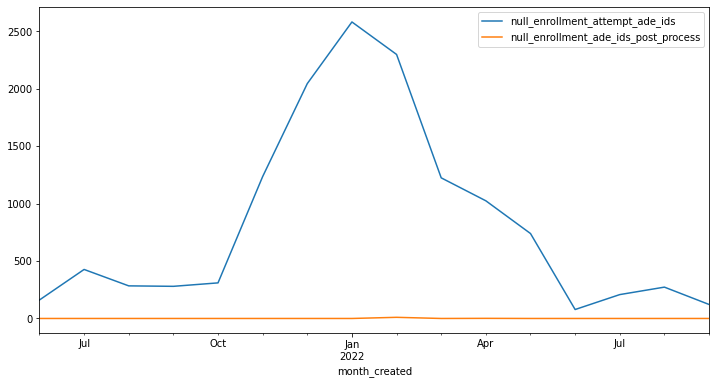

In [26]:
enrollments_out_df["month_created"] = enrollments_out_df[_time_created].dt.to_period("M")
null_enrollment_attempts_by_month_post_process =\
    enrollments_out_df[_ade_id].isnull().groupby(enrollments_out_df["month_created"]).sum().rename("null_enrollment_ade_ids_post_process")

compare_x = null_enrollment_attempts_by_month.to_frame().join(null_enrollment_attempts_by_month_post_process)
compare_x.plot.line(figsize=(12, 6))

## MRPs / CMMs

<AxesSubplot:xlabel='month_created'>

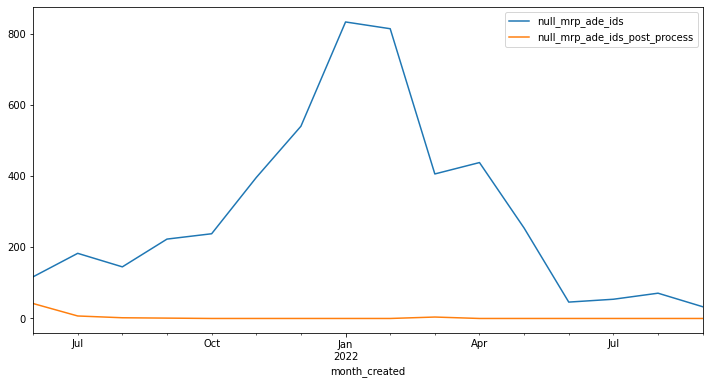

In [27]:
mrps_out_df["month_created"] = mrps_out_df[_time_created].dt.to_period("M")
null_mrps_by_month_post_process = mrps_out_df[_ade_id].isnull().groupby(
    mrps_out_df["month_created"]).sum().rename("null_mrp_ade_ids_post_process")

compare_mrps = null_mrps_by_month.to_frame().join(null_mrps_by_month_post_process)
compare_mrps.plot.line(figsize=(12, 6))

## MAP Sends

<AxesSubplot:xlabel='month_created'>

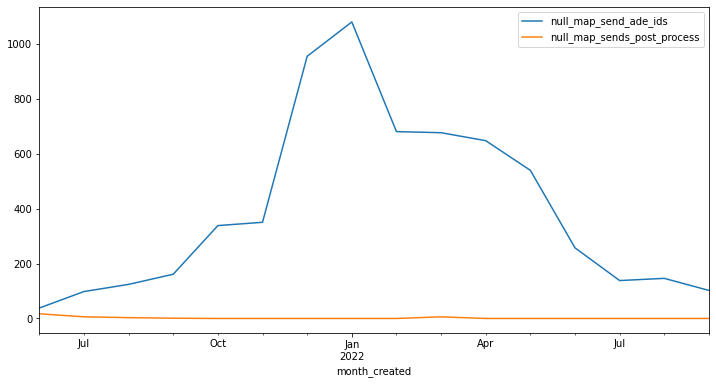

In [28]:
map_sends_out_df["month_created"] = map_sends_out_df[_time_created].dt.to_period("M")
null_map_sends_by_month_post_process =\
    map_sends_out_df[_ade_id].isnull().groupby(map_sends_out_df["month_created"]).sum().rename("null_map_sends_post_process")

compare_map_sends = null_map_sends_by_month.to_frame().join(null_map_sends_by_month_post_process)
compare_map_sends.plot.line(figsize=(12, 6))

## Medlists

<AxesSubplot:xlabel='month_created'>

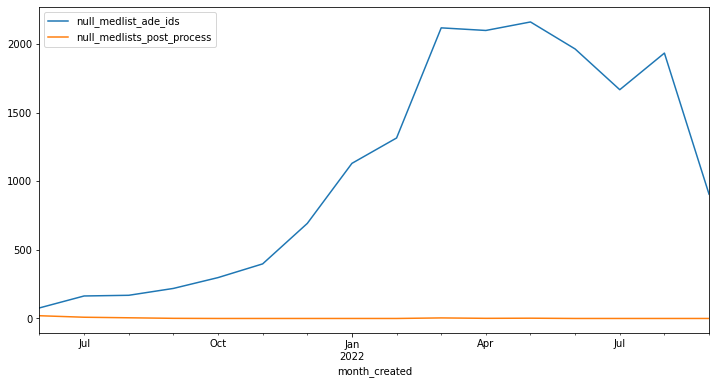

In [29]:
medlists_out_df["month_created"] = medlists_out_df[_time_created].dt.to_period("M")
null_medlists_by_month_post_process = medlists_out_df[_ade_id].isnull().groupby(
    medlists_out_df["month_created"]).sum().rename("null_medlists_post_process")

compare_medlists = null_medlists_by_month.to_frame().join(null_medlists_by_month_post_process)
compare_medlists.plot.line(figsize=(12, 6))

# Export

In [30]:
enrollment_diff_df = pd.merge(enrollment_attempts_df, enrollments_out_df, on=["id"], how="inner", suffixes=("_input", ""))
mrps_diff_df = pd.merge(enrollment_attempts_df, enrollments_out_df, on=["id"], how="inner", suffixes=("_input", ""))
map_sends_diff_df = pd.merge(enrollment_attempts_df, enrollments_out_df, on=["id"], how="inner", suffixes=("_input", ""))

In [31]:
enrollments_out_df = pd.DataFrame().from_records(enrollments_out)
enrollments_out_df = pd.merge(enrollment_attempts_df, enrollments_out_df, on=["id"], how="inner", suffixes=("_input", ""))
enrollments_out_df = enrollment_diff_df.loc[enrollment_diff_df[f"{_ade_id}_input"] != enrollment_diff_df[_ade_id]]

In [32]:
mrps_out_df = pd.DataFrame().from_records(mrps_out)
mrps_out_df = pd.merge(patient_mrps_df, mrps_out_df, on=["id"], how="inner", suffixes=("_input", ""))
mrps_out_df = mrps_out_df.loc[mrps_out_df[f"{_ade_id}_input"] != mrps_out_df[_ade_id]]

In [33]:
map_sends_out_df = pd.DataFrame().from_records(map_sends_out)
map_sends_out_df = pd.merge(patient_map_sends_df, map_sends_out_df, on=["id"], how="inner", suffixes=("_input", ""))
map_sends_out_df = map_sends_out_df.loc[map_sends_out_df[f"{_ade_id}_input"] != map_sends_out_df[_ade_id]]

In [ ]:
medlists_out_df = pd.DataFrame().from_records(medlists_out)
medlists_out_df = medlists_out_df.loc[medlists_out_df["associated_discharge_event_id"].isnull() == False]

In [ ]:
sf_tasks_out_df = pd.concat([enrollments_out_df, map_sends_out_df])
# sf_tasks_out_df.to_csv("sf_tasks_out.csv", index=False, columns=["id", _task_type, _ade_id])

In [ ]:
# mrps_out_df.to_csv("sf_events_out.csv", index=False, columns=["id", _event_type, _ade_id])

In [ ]:
# medlists_out_df.to_csv("medlists_out.csv", index=False, columns=["id", _ade_id])

# Redshift Testing

In [ ]:
engine.execute("TRUNCATE TABLE datascience.salesforce_task__ade_id_backfill;")
sf_tasks_out_df[["id", "associated_discharge_event_id", "task_type"]]\
    .to_sql("salesforce_task__ade_id_backfill", engine, index=False, schema="datascience", if_exists="append", method="multi", chunksize=1000)

engine.execute("TRUNCATE TABLE datascience.salesforce_event__ade_id_backfill;")
mrps_out_df[["id", "associated_discharge_event_id"]]\
    .to_sql("salesforce_event__ade_id_backfill", engine, index=False, schema="datascience", if_exists="append", method="multi", chunksize=1000)

engine.execute("TRUNCATE TABLE datascience.fact_medlist__ade_id_backfill;")
medlists_out_df[["id", "associated_discharge_event_id"]]\
    .to_sql("fact_medlist__ade_id_backfill", engine, index=False, schema="datascience", if_exists="append", method="multi", chunksize=1000)